In [44]:
import os
import matplotlib.pyplot as plt
from superlet import superlet, scale_from_period
import mne 
# from mne import create_info
import numpy as np
# from burst_detection import extract_bursts
from fooof import FOOOF
# from autoreject import AutoReject
import scipy.io

import pandas as pd
# from matplotlib import ticker
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import RobustScaler
# import seaborn as sns

In [11]:
data_dir='/home/common/bonaiuto/stop_go_bursts/data/'

In [12]:
SSD = scipy.io.loadmat(os.path.join(data_dir, 'Dataset_1/Study5_BEH_data/S1_SSD_stop.mat'))
SSD_data = SSD['num_align2']
df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
# average value over all trials
SSD_val = df_SSD['Value'].mean()
SSD_val

131.97916666666666

In [14]:
data_path = os.path.join(data_dir, 'Dataset_1/Study5_EEG_data/')
electrodes = ['C3', 'F4'] # , 'C4', 'F3', 'FCz'
subject_ids =  ['S1', 'S2', 'S3', 'S5', 'S6', 'S7', 'S8', 'S10', 'S11','S13', 'S14', 'S15']

In [17]:
subject_id=subject_ids[0]
subject_file = data_path + subject_id + '_stop_eeg_emg_ica_brain.set'
print(f"Processing {subject_id}")
raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})

Processing S1
Reading /home/common/bonaiuto/stop_go_bursts/data/Dataset_1/Study5_EEG_data/S1_stop_eeg_emg_ica_brain.fdt


/home/bonaiuto/miniconda3/envs/auditory_laminar/lib/python3.7/site-packages/mne/io/eeglab/eeglab.py:152: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if d.get("type", None) != 'FID':
/home/bonaiuto/tmp/ipykernel_55201/3190478549.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
/home/bonaiuto/tmp/ipykernel_55201/3190478549.py:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
/home/bonaiuto/tmp/ipykernel_55201/3190478549.py:4: RuntimeWarning: Not setting positions of 3 eog channels found in montage:
['HEOG L', 'HEOG R', 'VEOG']
Consider setting the channel types

<RawEEGLAB | S1_stop_eeg_emg_ica_brain.fdt, 62 x 2016057 (3937.6 s), ~87 kB, data not loaded>

In [21]:
SSD = scipy.io.loadmat(os.path.join(data_dir, f'Dataset_1/Study5_BEH_data/{subject_id}_SSD_stop.mat'))
SSD_data = SSD['num_align2']
df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
# average value over all trials
SSD_val = df_SSD['Value'].mean()

In [25]:
SSD_val

131.97916666666666

In [31]:
builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
montage = mne.channels.make_standard_montage("easycap-M1")
raw.set_montage(montage, verbose=False)
events, event_id = mne.events_from_annotations(raw)
# shift 'L_cueCG' and 'R_cueCG' events by SSD value
events_shift = events.copy()
for i in range(len(events)):
    if events_shift[i][2] == 1 or events_shift[i][2] == 9:
        events_shift[i][0] = events_shift[i][0] + SSD_val

epochs = mne.Epochs(raw, events=events, picks = 'eeg', event_id = event_id, tmin=-1, tmax=2, baseline = None, event_repeated='merge', preload = True)
epochs = mne.preprocessing.compute_current_source_density(epochs)

Used Annotations descriptions: ['L_cueCG', 'L_cueFS', 'L_cueGE', 'L_cueGM', 'L_cueSS', 'L_resp', 'L_stopsigFS', 'L_stopsigSS', 'R_cueCG', 'R_cueFS', 'R_cueGE', 'R_cueGM', 'R_cueSS', 'R_cue_stop', 'R_resp', 'R_stopsig', 'R_stopsigFS', 'R_stopsigSS', 'boundary', 'fix']
Multiple event values for single event times found. Creating new event value to reflect simultaneous events.
Not setting metadata
4827 matching events found
No baseline correction applied
0 projection items activated
Loading data for 4827 events and 1537 original time points ...
1 bad epochs dropped
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 0.0 40.1 mm
Origin device coordinates:    0.0 0.0 40.1 mm


In [32]:
epochs

Number of events,4826
Events,L_cueCG: 515L_cueFS: 103L_cueGE: 1L_cueGM: 6L_cueSS: 86L_resp: 601L_resp/boundary: 1L_stopsigFS: 102L_stopsigSS: 86R_cueCG: 548R_cueFS: 94R_cueGE: 4R_cueGM: 1R_cueSS: 93R_cue_stop: 2R_resp: 611R_resp/boundary: 1R_stopsig: 2R_stopsigFS: 93R_stopsigSS: 93boundary: 342fix: 1441
Time range,-1.000 – 2.000 sec
Baseline,off


In [33]:
frequencies = np.arange(1, 40, 1) 
n_cycles = frequencies / 2  

SS = epochs['L_stopsigSS', 'R_stopsigSS']
FS = epochs['L_stopsigFS', 'R_stopsigFS']
GO = epochs['L_cueCG', 'R_cueCG']

conditions = {'SS': SS, 'FS': FS, 'GO': GO}

In [34]:
SS

Number of events,179
Events,L_stopsigSS: 86R_stopsigSS: 93
Time range,-1.000 – 2.000 sec
Baseline,off


In [35]:
condition_name='SS'
condition=conditions[condition_name]
electrode=electrodes[0]

In [38]:
times = condition.times
ch_idx = condition.ch_names.index(electrode)
trials = condition.get_data()[:, ch_idx, :]

sfreq = condition.info['sfreq']
max_freq = 120
foi = np.linspace(1, max_freq, 120)
scales = scale_from_period(1/foi)
tf_trials = []

for trial in trials:
    tf = superlet(
        trial, sfreq, scales, 40, c_1=4, adaptive=True
    )
    tf_trials.append(np.single(np.abs(tf)))
tf_trials = np.array(tf_trials)

In [77]:
average_psd = np.average(tf_trials, axis=(2, 0))

ff = FOOOF()
ff.fit(foi, average_psd, [1, 120])
ap = 10 ** ff._ap_fit 


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



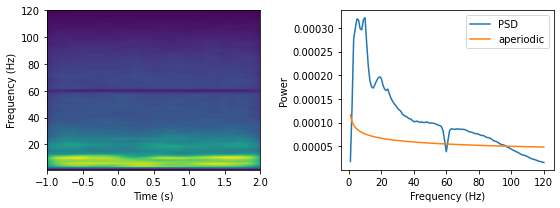

In [78]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(tf_trials,axis=0),aspect='auto',extent=[times[0], times[-1], foi[0], foi[-1]], origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.subplot(1,2,2)
plt.plot(foi,average_psd,label='PSD')
plt.plot(foi,ap,label='aperiodic')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()

In [79]:
average_psd = np.average(tf_trials, axis=(2, 0))

ff = FOOOF()
ff.fit(foi, average_psd, [3, 50])
ap = 10 ** ff._ap_fit 


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



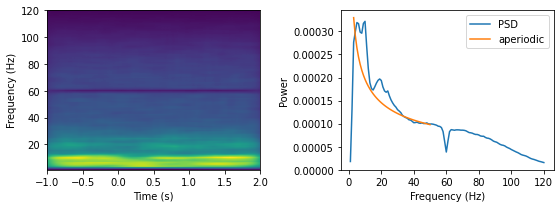

In [80]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(np.mean(tf_trials,axis=0),aspect='auto',extent=[times[0], times[-1], foi[0], foi[-1]], origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.subplot(1,2,2)
plt.plot(foi, average_psd,label='PSD')
plt.plot(foi[(foi>=3) & (foi<=50)], ap,label='aperiodic')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()

In [13]:


bursts_all_results_laplac = []

for subject_id in subject_ids:
    subject_file = data_path + subject_id + '_stop_eeg_emg_ica_brain.set'
    print(f"Processing {subject_id}")
    raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
    raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})

    SSD = scipy.io.loadmat(f'/Users/quentinmoreau/Documents/Work/schmidt_bursts/Data_Scripts_for_OSF/Dataset_1/Study5_BEH_data/{subject_id}_SSD_stop.mat')
    SSD_data = SSD['num_align2']
    df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
    # average value over all trials
    SSD_val = df_SSD['Value'].mean()

    builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
    montage = mne.channels.make_standard_montage("easycap-M1")
    raw.set_montage(montage, verbose=False)
    events, event_id = mne.events_from_annotations(raw)
    # shift 'L_cueCG' and 'R_cueCG' events by SSD value
    events_shift = events.copy()
    for i in range(len(events)):
        if events_shift[i][2] == 1 or events_shift[i][2] == 9:
            events_shift[i][0] = events_shift[i][0] + SSD_val

    epochs = mne.Epochs(raw, events=events, picks = 'eeg', event_id = event_id, tmin=-1, tmax=2, baseline = (-.2, 0), event_repeated='merge', preload = True)
    epochs = mne.preprocessing.compute_current_source_density(epochs)

    SS = epochs['L_stopsigSS', 'R_stopsigSS']
    FS = epochs['L_stopsigFS', 'R_stopsigFS']
    GO = epochs['L_cueCG', 'R_cueCG']

    conditions = {'SS': SS, 'FS': FS, 'GO': GO}

    for condition_name, condition in conditions.items():
        for electrode in electrodes:
            times = condition.times
            ch_idx = condition.ch_names.index(electrode)
            trials = condition.get_data()[:, ch_idx, :]

            sfreq = condition.info['sfreq']
            max_freq = 120
            foi = np.linspace(1, max_freq, 120)
            scales = scale_from_period(1/foi)
            tf_trials = []

            for trial in trials:
                tf = superlet(
                    trial, sfreq, scales, 40, c_1=4, adaptive=True
                )
                tf_trials.append(np.single(np.abs(tf)))
            tf_trials = np.array(tf_trials)

            average_psd = np.average(tf_trials, axis=(2, 0))

            ff = FOOOF()
            ff.fit(foi, average_psd, [1, 120])
            ap = 10 ** ff._ap_fit 

            search_range = np.where((foi >= 10) & (foi <= 33))[0]
            beta_lims = [13, 30]

            bursts = extract_bursts(
                trials, tf_trials[:,search_range], times, 
                foi[search_range], beta_lims, 
                ap[search_range].reshape(-1, 1), sfreq
            )
            experiment  = 'Exp1'
            epochs = 'Stop'
            bursts['condition'] = np.tile(condition_name, bursts['trial'].shape)
            bursts['electrode'] = np.tile(electrode, bursts['trial'].shape)
            bursts['subject'] = np.tile(subject_id, bursts['trial'].shape)
            bursts['experiment'] = np.tile(experiment, bursts['trial'].shape)
            bursts['epochs'] = np.tile(epochs, bursts['trial'].shape)

            bursts_all_results_laplac.append(bursts)

            # f, ax = plt.subplots(1, 1, figsize=(5, 5))
            # mean_waveform = np.mean(bursts["waveform"], axis=0)
            # ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2);
            # ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black");
            # ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
            # ax.set_title(f"{condition_name} - Electrode {electrode}")

path = '/home/common/bonaiuto/stop_go_bursts/derivatives/Dataset_1/bursts_all_results_laplac.npy'
# save bursts_all_results as npy
np.save(f'{path}/bursts_all_results_laplac.npy', bursts_all_results_laplac)


NameError: name 'mne' is not defined